In [2]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import sys
from importlib import reload


from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LinearRegression
from sklearn.manifold import TSNE
import torch as t
from sklearn.metrics import classification_report

# sys.path.append("~/Documents/Prog/LLMs/mri_llm")
sys.path.append("..") # Adds higher directory to python modules path.

from datas import celebrity, conspiracy, english_word, character

In [3]:
files_root = "../inference_data/"
files = [
    # "inference_conspiracy_character_sentence_908.pkl",
    # "inference_conspiracy_711.pkl",
    # "inference_character_474.pkl",
    # "inference_celebrity_random_764.pkl",
    # "inference_celebrity_285.pkl",
    # "inference_english_word_236.pkl",
    # "inference_date_884.pkl",
    # "inference_election_195.pkl",
    # "inference_date_election_648.pkl",

    # "inference_conspiracy_horizontal_593.pkl",
    # "inference_character_horizontal_945.pkl",
    # "inference_conspiracy_unrelated_545.pkl"

    # "inference_celebrity_horizontal_604.pkl",
    # "inference_english_word_horizontal_252.pkl",

    # "inference_celebrity_horizontal_token_952.pkl",
    # "inference_english_word_horizontal_token_78.pkl",

    "inference_english_word_nonnorm_874.pkl",
    "inference_french_word_612.pkl",
    "inference_celebrity_nonnorm_326.pkl",
]

data_list=[]
for f in files:
    with open(files_root+f, "rb") as fp:
        data_list.extend(pickle.load(fp))

In [4]:
print(len(data_list))
print(data_list[0].system_prompt)
print(data_list[0].user_prompt)
print(data_list[0].input_text)
print(data_list[0].output_text)

735
Always respond with a SINGLE sentence. You are given an english word, give me a short definition.
{}:
Time
Time is the measure of the duration of events or periods, often measured in seconds, minutes, hours, days, weeks, months, or years.


In [5]:
def type_of_input_labeling(data_elmt):
    label = data_elmt.label
    match data_elmt.__class__.__name__:
        # HALLUCINATION STUFF
        case "celebrity":
            label += 0
        case "conspiracy":
            label += 2*2
        case "english_word":
            label += 2*1
        case "french_word":
            label += 2*2
        # TIME STUFF
        case "date":
            label += 0
        case "election": # Carefull this guy has 3 switches
            label += 2*1
        # FICTION STUFF
        case "character":
            label += 0
        case _ :
            raise Exception("Error of non recognised type of data element")

    if data_elmt.sufix and data_elmt.sufix== "random":
        label = data_elmt.label + 2
        
    return label

In [6]:
X = np.array([[data_list[i].activations[lay_nb][0].type(t.float64).cpu().numpy() for lay_nb in range(len(data_list[i].activations))] for i in range(len(data_list))])
Y = np.array([type_of_input_labeling(data_list[i]) for i in range(len(data_list))])

# torch.stack().type(torch.float64).cpu().numpy()
print(len(X))
print(len(X[0]))
print(len(X[0][0]))
print(X[0][0])
print(Y)

from collections import Counter
print(Counter(Y))

735
1
4096
[-0.03344727  0.20117188 -0.06591797 ...  0.17480469  0.328125
 -0.05566406]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5

In [7]:
color_selction = ["#ef6c00", "#eeff41", "#009668", "#ce93d8" , "#a1e8d9", "#b3a77d", "#6a634a", "red", "green"]

def simple_label2color(label):
    # labels are 4 choices
    color = color_selction[label]
    return color

def bidim_label2color(label):
    # labels are 2*2*2 choices
    color = color_selction[label[1] + 2*label[2]]
    # color = mcolors.CSS4_COLORS[color_selction[label[1] + 2*label[2]]]
    return color

## Add some labels according to other conditions

- Length of output

In [8]:
def output_length_label(data_elmt):
    return len(data_elmt.output_text)
    # if len(data_elmt.output_text) > 100:
    #     return "long_output"
    # else:
    #     return "short_output"

for i in range(len(data_list)):
    data_list[i].output_length = output_length_label(data_list[i])
    data_list[i].class_type = data_list[i].__class__.__name__


In [9]:
def normlise_by_data_type(data_list, states):
    type_indices = {}
    for i in range(len(data_list)):
        # Select according to certain parameter, for exemple class type of data
        data_type = data_list[i].__class__.__name__
        if data_type in type_indices:
            type_indices[data_type].append(i)
        else:
            type_indices[data_type] = [i]
    for key in type_indices:
        indices = np.array(type_indices[key])
        states[indices] = states[indices] - states[indices].mean(axis=0)

    return states

In [10]:
# TSNE plot stuff
def plot_tsne(X, Y):
    inp = np.array([x for x in X])
    y = np.array([yy for yy in Y]) # list(range(len(data_el.activations[0])))

    tsne = TSNE(n_components=2, perplexity=40, n_iter=300)
    res = tsne.fit_transform(inp)

    plt.scatter(res[:, 0], res[:, 1], c=y)
    plt.show()

In [38]:
def tensor2array(te):
    return te.type(t.float64).detach().cpu().numpy()

def activation_selection(data_el):

    if data_el.sufix == "horizontal" or data_el.sufix == "horizontal+token":
        # For the only layer there is, we divide activation between prompt and generated text
        end_of_prompt_id = len(data_el.prompt_token_emb) - 1 #data_el.input_token_length-1     # add -1 because during process of last prompt token we are alreaddy generating new content.

        normalised_by_input = t.stack(data_el.activations[0].copy()).detach()
        all_input_seq = t.cat((data_el.prompt_token_emb, data_el.gen_token_emb), dim=0).detach()

        # print(normalised_by_input.shape)
        # print(all_input_seq.shape)

        # print(normalised_by_input.mean())
        # print(normalised_by_input.max())
        # print(normalised_by_input.min())
        # print(normalised_by_input.abs().min())
        # print(all_input_seq.mean())
        # print(all_input_seq.mean())
        # print(all_input_seq.min())
        # print(all_input_seq.abs().min())

        # all_input_seq = (all_input_seq - t.min(all_input_seq, dim=0) by_input, dim=0).values) / (t.max(normalised_by_input, dim=0).values - t.min(normalised_by_input, dim=0).values)


        # normalised_by_input = normalised_by_input - all_input_seq[end_of_prompt_id:].mean(dim=0)

        # Substract previous activation and also input token
        # base_act = normalised_by_input[0]
        # for i in range(len(normalised_by_input)):
        #     normalised_by_input[i] = normalised_by_input[i] - base_act 
            # if i>0:
            #     normalised_by_input[i] = normalised_by_input[i] - normalised_by_input[i-1]

            # normalised_by_input[i] = normalised_by_input[i] - all_input_seq[i]
                
            


        # Substract input token from the same column of generation
        # for i in range(len(normalised_by_input)):
        #     normalised_by_input[i] = normalised_by_input[i] - all_input_seq[i]

        prompt_activations = normalised_by_input[0:end_of_prompt_id]
        generated_activations = normalised_by_input[end_of_prompt_id:]

    # test 1: Sum(gen_act) - Sum(promp_act)
    # result = t.stack(generated_activations).sum(dim=0) - t.stack(prompt_activations).sum(dim=0)
    # # Seems to create even more difference between datasets

    # # test 2: the baseline just last line
    # result = generated_activations[-1]

    # # test 3: add generated tokens
    # result = generated_activations.sum(dim=0)

    # test 4: add all tokens
    # result = t.stack(prompt_activations + generated_activations).sum(dim=0)

    # test 5: concatenate last 2 gen tokens
    # result = t.cat(generated_activations[-2:])

    # # test 6: ultipenultime gen tokens
    # result = generated_activations[-2]

    # # test 7: mean of each row of gen tokens
    # result = generated_activations.mean(dim=0)

    # # test 8: mean of each row of gen tokens sub promp mean
    result = generated_activations.mean(dim=0) - prompt_activations.mean(dim=0)

    # test 8.1: Mean of all activation of line X
    # result = normalised_by_input.mean(dim=0)

    # test 8.2: Concatenate { input token : Mean of gen - mean of prompt : last generated token
    # result = t.cat([generated_activations.mean(dim=0) - prompt_activations.mean(dim=0), generated_activations[-1], all_input_seq[end_of_prompt_id:].mean(dim=0)], dim=0)


    # # test 9: Clipped to threshold + mean gen
    # clip_value = 3
    # result = t.clip(t.stack(generated_activations), min=clip_value, max=None)
    # result[result == clip_value] = 0
    # # print(result[0])
    # result = result.mean(dim=0)

    # # test 10: Clipped to threshold + mean gen + sub mean of same prompt token
    # clip_value = 1
    # a = t.clip(t.abs(t.stack(generated_activations)), min=clip_value, max=None)
    # p = t.clip(t.abs(t.stack(prompt_activations)), min=clip_value, max=None)
    # a[a == clip_value] = 0
    # p[p == clip_value] = 0
    # result = a.mean(dim=0) - p.mean(dim=0)

    # test 11: mean gen - prompt, then threshold
    # clip_value = 2
    # result = t.clip(t.stack(generated_activations).mean(dim=0) - t.stack(prompt_activations).mean(dim=0), min=clip_value, max=None)
    # result[result == clip_value] = 0

    # print(result.shape)
    return  tensor2array(result)


out = activation_selection(data_list[0])
print(out)
# print(len(np.where(out>0)[0]))

[-0.00610352 -0.05078125  0.00622559 ...  0.05029297  0.05249023
 -0.06835938]


In [39]:
def train_and_fit_flat(train_condition, mode="PCA", get_projection=False, group_norm=False):
    X = np.array([activation_selection(data_list[i]) for i in range(len(data_list))])
    Y = np.array([type_of_input_labeling(data_list[i]) for i in range(len(data_list))])

    # Do a PCA projection for each layer
    layer_pca = []
    pca_training_data_indices = np.array(list(filter(train_condition, enumerate(data_list))))[:, 0]
    print("Size of training data:", len(pca_training_data_indices))

    # Train on one problem
    data_states = X
    if group_norm:
        data_states = normlise_by_data_type(data_list, data_states)
    if mode=="PCA":
        pca = PCA(n_components=4)
        train_d = [data_states[i] for i in pca_training_data_indices]
        pca.fit(train_d)
        train_d -= np.mean(train_d, axis=0)
        cov_matrix = np.dot(train_d.T, train_d) / len(train_d)
        for eigenvector in pca.components_:
            print("Eigenvalue: ", np.dot(eigenvector.T, np.dot(cov_matrix, eigenvector)))
    elif mode=="LDA":
        pca = LDA(n_components=1)
        pca.fit([data_states[i] for i in pca_training_data_indices], [Y[i] for i in pca_training_data_indices])
    elif mode=="FA":
        pca = FactorAnalysis(n_components=2, rotation="varimax")
        pca.fit([data_states[i] for i in pca_training_data_indices], [Y[i] for i in pca_training_data_indices])

    x = pca.transform(data_states)

    # Every label is multiplied by the number of layers in order to have a data point for each input x layer
    # Labels
    input_text = np.array([data_list[i].input_text  for i in range(len(data_list))])
    data_type = np.array([data_list[i].__class__.__name__  for i in range(len(data_list))])
    output_length = np.array([data_list[i].output_length  for i in range(len(data_list))]) 
    swtich = np.array([data_list[i].switch_name  for i in range(len(data_list))])
    output_text = np.array([data_list[i].output_text  for i in range(len(data_list))])
    sufix = np.array([1 if data_list[i].sufix else 0  for i in range(len(data_list))])

    if mode=="PCA":
        df = pd.DataFrame(zip(x[:, 0], x[:, 1], x[:, 2], x[:, 3], input_text, Y, data_type, output_length, swtich, output_text, sufix), 
                    columns=['pca1', 'pca2', 'pca3', 'pca4', "input/output", "label", "data_type", "output_length", "switch", "output_text", "sufix"])
    elif mode=="LDA":
        df = pd.DataFrame(zip(x[:, 0], input_text, Y, data_type, output_length, swtich, output_text, sufix), 
                    columns=['pca1', "input/output", "label", "data_type", "output_length", "switch", "output_text", "sufix"])
    elif mode=="FA":
        df = pd.DataFrame(zip(x[:, 0], x[:, 1], input_text, Y, data_type, output_length, swtich, output_text, sufix), 
                    columns=['pca1', 'pca2', "input/output", "label", "data_type", "output_length", "switch", "output_text", "sufix"])

    if get_projection:
        return df, pca
    return df

In [40]:
def train_and_fit_pca(train_condition, mode="PCA"):
    X = np.array([activation_selection(data_list[i]) for i in range(len(data_list))])
    Y = np.array([type_of_input_labeling(data_list[i]) for i in range(len(data_list))])

    label_colors = [simple_label2color(y) for y in Y]

    # Do a PCA projection for each layer
    layer_pca = []
    layer_id = []
    pca_training_data_indices = np.array(list(filter(train_condition, enumerate(data_list))))[:, 0]
    print("Size of training data:", len(pca_training_data_indices))
    for layer_nb in range(32):
        # Train on one problem
        data_states = X[:, layer_nb]
        data_states = normlise_by_data_type(data_list, data_states)
        if mode=="PCA":
            pca = PCA(n_components=2)    
            train_d = [data_states[i] for i in pca_training_data_indices]
            pca.fit(train_d)
            train_d -= np.mean(train_d, axis=0)
            cov_matrix = np.dot(train_d.T, train_d) / len(train_d)
            for eigenvector in pca.components_:
                print("Eigenvalue: ", np.dot(eigenvector.T, np.dot(cov_matrix, eigenvector)))
        elif mode=="LDA":
            pca = LDA(n_components=1)    
            pca.fit([data_states[i] for i in pca_training_data_indices], [Y[i] for i in pca_training_data_indices])
        x = pca.transform(data_states)
        layer_pca.extend(x)
        a = np.empty(len(x))
        a.fill(layer_nb)
        layer_id.extend(a)

    layer_pca = np.array(layer_pca)
    layer_id = np.array(layer_id)

    # Every label is multiplied by the number of layers in order to have a data point for each input x layer
    # Labels
    # y = np.array([data_list[i].label for i in range(len(data_list))])
    y_layered = np.tile(Y, (32))

    input_text = np.array([data_list[i].input_text  for i in range(len(data_list))])
    inputs_layered = np.tile(input_text, 32)

    data_type = np.array([data_list[i].__class__.__name__  for i in range(len(data_list))])
    data_type_layered = np.tile(data_type, 32)

    output_length = np.array([data_list[i].output_length  for i in range(len(data_list))]) 
    output_length_layered = np.tile(output_length, 32)

    swtich = np.array([data_list[i].switch_name  for i in range(len(data_list))])
    swtich_layered = np.tile(swtich, 32)

    output_text = np.array([data_list[i].output_text  for i in range(len(data_list))])
    output_text_layered = np.tile(output_text, 32)

    sufix = np.array([1 if data_list[i].sufix else 0  for i in range(len(data_list))])
    sufix_layered = np.tile(sufix, 32)

    if mode=="PCA":
        df = pd.DataFrame(zip(layer_pca[:, 0], layer_pca[:, 1], inputs_layered, layer_id, y_layered, data_type_layered, output_length_layered, swtich_layered, output_text_layered, sufix_layered), 
                    columns=['pca1', 'pca2', "input/output", "layer_id", "label", "data_type", "output_length", "switch", "output_text", "sufix"])
    elif mode=="LDA":
        df = pd.DataFrame(zip(layer_pca[:, 0], inputs_layered, layer_id, y_layered, data_type_layered, output_length_layered, swtich_layered, output_text_layered, sufix_layered), 
                    columns=['pca1', "input/output", "layer_id", "label", "data_type", "output_length", "switch", "output_text", "sufix"])

    return df

In [41]:
# TRAIN PCA

train_condition_fun = lambda el: el[1].__class__.__name__ in ["french_word"] and len(el[1].output_text) > 10 #, "french_word"] #and len(el[1].output_text) > 10 #and el[1].input_text in ["Time", "Blorble", "blorple", "Teacher"]
df, proj = train_and_fit_flat(train_condition_fun, mode="PCA", get_projection=True, group_norm=True)

Size of training data: 210
Eigenvalue:  1.6927718572083361
Eigenvalue:  0.9427927287840296
Eigenvalue:  0.60493044690117
Eigenvalue:  0.29518286286785955


In [42]:
df[(df["data_type"] == "english_word") & (df["label"]== 2)]

,pca1,pca2,pca3,pca4,input/output,label,data_type,output_length,switch,output_text,sufix
0,1.805943,1.249200,-0.712739,-0.382575,Time,2,english_word,131,real,Time is the measure of the duration of events ...,1
1,2.125493,0.518832,-0.841861,-0.654143,Year,2,english_word,97,real,"A year is a unit of time equal to 365.24 days,...",1
2,2.023821,1.542811,-0.277542,-0.562998,People,2,english_word,74,real,"A group of human beings, including individuals...",1
3,1.498453,1.487503,-0.324737,0.145897,Way,2,english_word,99,real,"A way is a path or route, typically on foot or...",1
4,1.819127,0.883333,-0.749241,-0.260794,Day,2,english_word,105,real,"A day is a unit of time, equivalent to 24 hour...",1
...,...,...,...,...,...,...,...,...,...,...,...
93,1.834022,1.340417,0.612840,-0.046438,Moment,2,english_word,114,real,"A moment is a brief instant or point in time, ...",1
94,1.980397,0.721548,-1.091119,-0.406992,Air,2,english_word,105,real,Air is the invisible mixture of gases that sur...,1
95,1.659733,1.670298,-0.740747,-0.076958,Teacher,2,english_word,143,real,A teacher is an individual who educates and gu...,1
96,1.748493,1.925999,-0.049101,-0.244874,Force,2,english_word,100,real,Force is the application of energy or strength...,1


In [43]:
# print(df[(df["data_type"] == "conspiracy") & (df["output_length"] is not None)& (df["label"] == 2) & (df["input/output"] == "Watergate Scandal") & (df["layer_id"] == 16)]["output_text"].item())

In [45]:

# df_modified = df[df["label"] ]
# df_modified = df[df["layer_id"] == 16]
# df_modified = df_modified[(df_modified["label"] < 2) | (df_modified["label"] > 3)]
# df_modified = df_modified[df_modified["sufix"] == 1]
# df_modified = df_modified[df_modified["output_length"] < 20]
# print(df_modified.head()["label"])
# print(set(df_modified[data_type]))
df_modified = df.copy()
df_modified["label"] = df_modified["label"].astype(str)
df_modified["random_value"] = np.random.rand(len(df_modified))

scatter = px.scatter(df_modified, x='pca1', y='pca2',
                     color="label",
                    #  size='output_length', 
                     symbol= "data_type",
                     hover_data=["input/output", "output_length", "switch"],
                     color_discrete_sequence=color_selction)

scatter.update_layout(
    # autosize=True,
    width=1000,
    height=700,)

scatter.update_layout(coloraxis_colorbar=dict(yanchor="top", y=1, x=-0.2,
                                          ticks="outside"))

scatter.show()

In [46]:
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import StandardScaler



## Save additive vector from the projcetion



In [47]:
vect_length = len(data_list[0].activations[0][0])
print(vect_length)
# vect_length = 12288
x = np.array([10]*vect_length)
print(x)
x = proj.transform([x])
print(x)

# LDA give the proj matrix:
if False:
    print(proj.scalings_.shape)
    w = proj.scalings_[:, 0]
    w_T_w = np.dot(w, w)
    xn = (1 / w_T_w) * w
    print(xn)
    print(proj.transform([xn]))

# PCA give the inverse transform of this values:
if True:
    class1 = df_modified[df_modified["label"] == "0"]
    class2 = df_modified[df_modified["label"]=="1"]
    mean1 = class1[["pca1", "pca2", "pca3", "pca4"]].to_numpy().mean(axis=0)
    mean2 = class2[["pca1", "pca2", "pca3", "pca4"]].to_numpy().mean(axis=0)

    print(mean1, mean2)

    proj_unit_delt = mean2 - mean1

    print(proj_unit_delt)

    proj_unit_delt = proj_unit_delt/np.linalg.norm(proj_unit_delt)

    print(proj_unit_delt)

    xn = proj.inverse_transform(proj_unit_delt * 3)
    print(xn)
    print(proj.transform([xn]))

    import pickle
    proj_file = open('../inference_data/proj2.pkl', 'wb')
    unit_file = open('../inference_data/unit_delta2.pkl', 'wb')
    pickle.dump(proj, proj_file)
    pickle.dump(proj_unit_delt, unit_file)
    proj_file.close() , unit_file.close()


4096
[10 10 10 ... 10 10 10]
[[2.64282891 8.13674013 7.81570091 4.60737426]]
[ 2.10133048  0.52419034 -0.19866566 -0.0039711 ] [ 2.40121153  0.21449456 -0.19526781  0.06069475]
[ 0.29988106 -0.30969579  0.00339785  0.06466585]
[ 0.68791396 -0.71042852  0.00779452  0.14834062]
[-0.0059908  -0.00675183  0.02288136 ...  0.02846429 -0.027327
 -0.01083517]
[[ 2.06374189 -2.13128557  0.02338357  0.44502187]]


## Use probes for quantitative evaluation

In [48]:
import probes
reload(probes)

<module 'probes' from '/home/thibaua25/Documents/Prog/LLMs/mri_llm/notebooks/../probes.py'>

In [58]:
# split data
split_condition1 = df["data_type"]=="french_word"
split_condition2 = df["output_length"] < 10
train_df = df[split_condition1]
eval_df = df[~split_condition1]

# layernb = 16
# train_df = train_df[train_df["layer_id"] == layernb]
# eval_df = eval_df[eval_df["layer_id"] == layernb]


# format for training
# x = train_df[['pca1', 'pca2', 'pca3', 'pca4']].to_numpy()
x = train_df[['pca1', 'pca2']].to_numpy()
# x = train_df[['pca1']].to_numpy()
y = train_df['label'].to_numpy()
y = y - np.min(y)

# train mean mass probe
mmp = probes.MMProbe.from_data(x, y)

# trian Linear separation
from sklearn import svm
reg = svm.SVC().fit(x, y)
reg.score(x, y)

0.883248730964467

In [59]:
# eval data
# x_eval = eval_df[['pca1', 'pca2', 'pca3', 'pca4']].to_numpy()
x_eval = eval_df[['pca1', 'pca2']].to_numpy()
# x_eval = eval_df[['pca1']].to_numpy()
y_eval = eval_df['label'].to_numpy()
y_eval = y_eval - np.min(y_eval)

# print(y_eval)
MM_prediction = mmp.pred(x_eval)
reg_prediction = reg.predict(x_eval)
# print(MM_prediction.numpy())
# print(np.array(reg_prediction))

eval_df["MM_prediction"] = MM_prediction.numpy()
eval_df["reg_prediction"] = np.array(reg_prediction)

class_report = classification_report(y_eval, eval_df["MM_prediction"].to_numpy(), output_dict=True)
print("Total cases:", len(y_eval))
print("MMP Success cases:", class_report["accuracy"]*len(y_eval))
print("MMP Failure cases:", (1 - class_report["accuracy"])*len(y_eval))
print("MMP F1 score:", class_report['macro avg']['f1-score'])
class_report = classification_report(y_eval, eval_df["reg_prediction"].to_numpy(), output_dict=True)
print()
print("REG Success cases:", class_report["accuracy"]*len(y_eval))
print("REG Failure cases:", (1 - class_report["accuracy"])*len(y_eval))
print("REG F1 score:", class_report['macro avg']['f1-score'])


Total cases: 341
MMP Success cases: 71.0
MMP Failure cases: 270.0
MMP F1 score: 0.1186349252013809

REG Success cases: 124.0
REG Failure cases: 217.0
REG F1 score: 0.2509968102073365


/tmp/ipykernel_2987235/1784266568.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2987235/1784266568.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/srv/public/Thibaud/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/srv/public/Thibaud/conda/lib/python3.10/site-packages/sklearn/metrics/_class

# Remove the data element with low confidence.

In [60]:
loggits = mmp(x_eval).cpu().numpy()

confidence = 0.5

# print(np.abs(loggits - 0.5))
confident_indices = np.where(np.abs(loggits - 0.5) > (0.5 - confidence/2))[0] 
# print(confident_indices)

class_report = classification_report(y_eval[confident_indices], eval_df["MM_prediction"].to_numpy()[confident_indices], output_dict=True)
print("Total cases:", len(y_eval), "confident cases:", len(y_eval[confident_indices]))
print("Success cases:", class_report["accuracy"]*len(y_eval[confident_indices]))
print("Failure cases:", (1 - class_report["accuracy"])*len(y_eval[confident_indices]))
print("F1 score:", class_report['macro avg']['f1-score'])

Total cases: 341 confident cases: 103
Success cases: 0.9999999999999999
Failure cases: 102.0
F1 score: 0.00641025641025641


/srv/public/Thibaud/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/srv/public/Thibaud/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/srv/public/Thibaud/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/srv/public/Thibaud/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter

# Plot Probe classification 2D

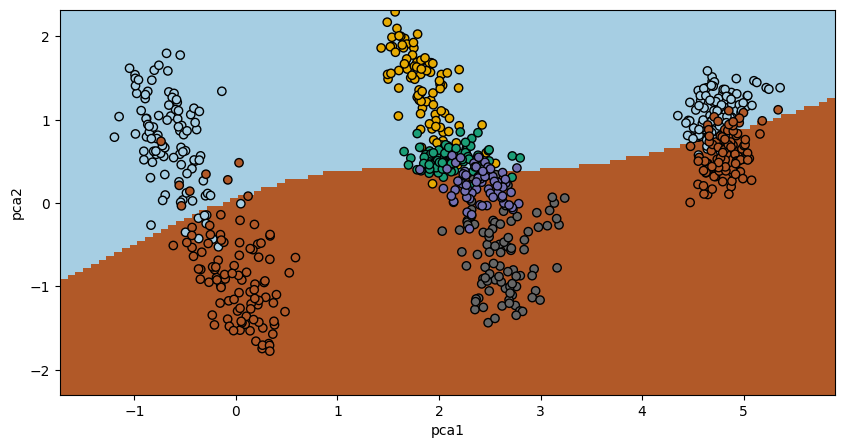

In [61]:
from sklearn.inspection import DecisionBoundaryDisplay

_, ax = plt.subplots(figsize=(10, 5))
DecisionBoundaryDisplay.from_estimator(
    reg,
    x,
    cmap=plt.cm.Paired,
    ax=ax,
    response_method="predict",
    plot_method="pcolormesh",
    shading="auto",
    xlabel="pca1",
    ylabel="pca2",
    eps=0.5,
)
plt.scatter(x[:, 0], x[:, 1], c=y, edgecolors="k", cmap=plt.cm.Paired)
plt.scatter(x_eval[:, 0], x_eval[:, 1], c=y_eval, edgecolors="k", cmap=plt.cm.Dark2)

In [62]:
eval_df["random_value"] = np.random.rand(len(eval_df))
eval_df["label"] = eval_df["label"] #+ 1

scatter = px.scatter(eval_df, x='pca1', y='pca2', 
                     color="label",
                     size="output_length", 
                     symbol= "MM_prediction",
                     hover_data=["input/output", "output_length", "switch"],
                     color_discrete_sequence=color_selction)

scatter.update_layout(
    # autosize=True,
    width=1000,
    height=700,)

scatter.update_layout(coloraxis_colorbar=dict(yanchor="top", y=1, x=-0.2,
                                          ticks="outside"))

scatter.add_vline(x=0, line_dash="dash", line_color="red")

scatter.show()

/tmp/ipykernel_2987235/2100144012.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2987235/2100144012.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

